# Extract population data for Brighton & Hove from Worldpop

**What is this?**

This notebook demonstrates how to process WorldPop population data. Here, we will convert the data from a 100 meter raster grid into a Point layer in which the centroid of the raster cell is used as a location for the point.

## Download the data

Download the raster dataset for UK from: https://hub.worldpop.org/geodata/summary?id=49903

In [2]:
import xarray as xr
import rioxarray as rx
import geopandas as gpd
from shapely.geometry import box

In [51]:
# Read raster data (i.e. the one downloaded from Worldpop hub) - Notice you need to download the data for this to work!
fp = "data/Brighton/gbr_ppp_2020_constrained.tif"
data = rx.open_rasterio(fp).squeeze("band", drop=True).to_dataset(name="population")

In [5]:
# Data extent for Brighton
bounds = (-0.49975, 50.73,  0.3469234, 50.98)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[box(*bounds)], crs="EPSG:4326")
gdf.explore()

In [17]:
# Clip the raster
data = data.rio.clip(gdf.geometry.values, gdf.crs, drop=True)

In [19]:
# Check what is the min value
data["population"].min()

<xarray.DataArray 'population' ()>
array(-99999., dtype=float32)
Coordinates:
    spatial_ref  int64 0

In [20]:
# Keep only values that are higher than 0
data["population"] = data["population"].where(data["population"] >=0)

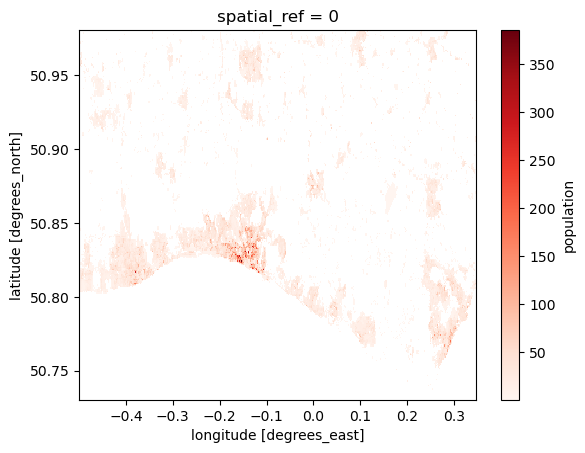

In [21]:
# Plot the population
data["population"].plot(cmap="Reds")

In [43]:
# Convert grid to points (a centroid of the cell is used as the location for the point)
df = data.to_dataframe().reset_index().drop(["spatial_ref"], axis=1)
df.head()

x          y  population
0 -0.499167  50.980000         NaN
1 -0.499167  50.979167         NaN
2 -0.499167  50.978333         NaN
3 -0.499167  50.977500         NaN
4 -0.499167  50.976667         NaN

In [44]:
# Create GeoDataFrame out of the points
df["geometry"] = gpd.points_from_xy(df["x"], df["y"])
gdf = gpd.GeoDataFrame(df, crs="epsg:4326")

# Drop points without population
gdf = gdf.loc[gdf["population"]>=0].copy()
gdf.head()

x          y  population                   geometry
9  -0.499167  50.972500   10.112679  POINT (-0.49917 50.97250)
10 -0.499167  50.971667   19.579712  POINT (-0.49917 50.97167)
11 -0.499167  50.970833   12.178864  POINT (-0.49917 50.97083)
14 -0.499167  50.968333    5.552000  POINT (-0.49917 50.96833)
15 -0.499167  50.967500    2.551825  POINT (-0.49917 50.96750)

<AxesSubplot: >

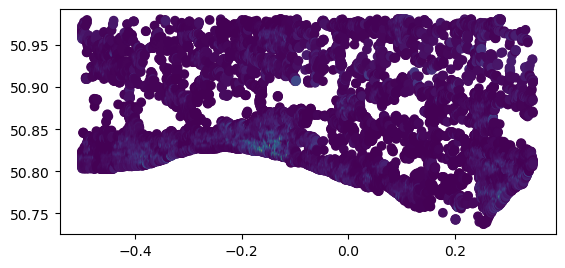

In [45]:
gdf.plot(column="population")

In [46]:
# Explore interactively
gdf.cx[-0.3:0.0, 50.8:50.88].explore(column="population")

In [49]:
# Add index as id for the point
gdf = gdf.reset_index(drop=True)
gdf["id"] = gdf.index
gdf.head()

x          y  population                   geometry  id
0 -0.499167  50.972500   10.112679  POINT (-0.49917 50.97250)   0
1 -0.499167  50.971667   19.579712  POINT (-0.49917 50.97167)   1
2 -0.499167  50.970833   12.178864  POINT (-0.49917 50.97083)   2
3 -0.499167  50.968333    5.552000  POINT (-0.49917 50.96833)   3
4 -0.499167  50.967500    2.551825  POINT (-0.49917 50.96750)   4

In [50]:
# Save data to file
gdf.to_file("data/Brighton/Brighton_pop_points_2020.gpkg", driver="GPKG")